In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import statistics as stats
from scipy import stats
import copy 



In [2]:
df_data = pd.read_csv("./01_data.csv", sep=";")
df_etalon = pd.read_csv("./02_etalon.csv", sep=";")

sns.set(rc={"figure.figsize":(15,10)})

In [3]:
# взглянем на данные
df_data

,lac,cid,ts,fulldate,hash_id
0,7755,35950,1.536391e+09,2018-09-13,1361396
1,7755,35950,1.536391e+09,2018-09-14,1361396
2,7752,19203,1.535967e+09,2018-09-04,1361396
3,7755,35950,1.536391e+09,2018-09-09,1361396
4,7752,19203,1.535967e+09,2018-09-05,1361396
...,...,...,...,...,...
9153687,7746,6552,1.537764e+09,2018-09-24,2241318
9153688,7716,28931,1.537504e+09,2018-09-21,2241318
9153689,9716,31053,1.537805e+09,2018-09-24,2241318
9153690,9752,13163,1.537765e+09,2018-09-24,2241318


In [4]:
# пустых значений нет
df_data.isnull().sum()

lac         0
cid         0
ts          0
fulldate    0
hash_id     0
dtype: int64

In [5]:
#сохраним эталонные пары
list_etalon1 = df_etalon.id1.values.tolist()
list_etalon2 = df_etalon.id2.values.tolist()
df_etalon

,id1,id2
0,1361396,2695335
1,1795864,2458905
2,1543059,2730453
3,1028066,2539971
4,1533076,2712514
...,...,...
486,1203418,2535912
487,1318608,2155223
488,1521509,2228448
489,1926205,2756992


In [6]:
# преобразуем timestamp в datetime и выделим часы, дату, день недели
df_data['time_date'] = pd.to_datetime(df_data.ts, unit='s')
df_data['time_hour'] = df_data.time_date.dt.hour
df_data['only_date'] = df_data.time_date.dt.date
df_data["weekday"] = df_data.time_date.dt.weekday

In [7]:
# удалим данные за 15 число - ведь об этих id по условию мы ничего не знаем
list_mistake_index = (df_data.loc[df_data.time_date.dt.day == 15].sort_values("only_date").index.to_list())
df_data = df_data.loc[~df_data.hash_id.isin(list_mistake_index)]

len(list_mistake_index)

2071

In [8]:
df_data.sort_values("only_date")
# можно заметить, что столбец fulldate содержит даты, которые не совпадают с ts, причем они соответствуют дубликатам записей, судя по одинаковым значениям lac, cid, ts
# также заметим, что начальная дата 2018-08-16 21:48:41 не соответствует условию ТЗ - что данные за 9 месяц с 1 по 30 число. 


,lac,cid,ts,fulldate,hash_id,time_date,time_hour,only_date,weekday
447663,7752,2446,1.534456e+09,2018-09-01,1305846,2018-08-16 21:48:41,21,2018-08-16,3
1006946,9754,197893635,1.535219e+09,2018-09-01,1570928,2018-08-25 17:36:09,17,2018-08-25,5
1675213,7755,30228,1.535205e+09,2018-09-01,1063793,2018-08-25 13:53:01,13,2018-08-25,5
3239372,7755,3240,1.535200e+09,2018-09-01,1714193,2018-08-25 12:30:24,12,2018-08-25,5
1675191,7755,30228,1.535205e+09,2018-09-02,1063793,2018-08-25 13:53:01,13,2018-08-25,5
...,...,...,...,...,...,...,...,...,...
5433083,9758,197924612,1.538336e+09,2018-09-30,2756992,2018-09-30 19:34:34,19,2018-09-30,6
5433084,9776,198724384,1.538311e+09,2018-09-30,2756992,2018-09-30 12:37:28,12,2018-09-30,6
5433085,9776,198724358,1.538311e+09,2018-09-30,2756992,2018-09-30 12:37:20,12,2018-09-30,6
7948165,9915,197659404,1.538321e+09,2018-09-30,2144004,2018-09-30 15:25:26,15,2018-09-30,6


In [9]:
# удалим столбец fulldate, отсечем данные до 2018-09-01, удалим дубликаты 
df_data = df_data.loc[df_data.only_date >= datetime.date(2018, 9, 1)]\
  .drop("fulldate", axis=1)\
    .sort_values("time_date")\
      .drop_duplicates(subset=['lac', 'cid',"ts","hash_id"],keep='first')

In [10]:
# имеем 4534/2 = 2267 пару id, а должно быть 2298 уникальных пользователей с парными id  - необходимо разобраться
df_data.hash_id.nunique()

4534

In [11]:
#сохраним списки id - со старыми и новыми id 
list_id1 = df_data.loc[df_data.time_date.dt.day < 15].hash_id.unique()
list_id1 = list_id1.tolist() 

list_id2 = df_data.loc[df_data.time_date.dt.day > 15].hash_id.unique()
list_id2 = list_id2.tolist()

In [12]:
# проверим, есть ли пересечения групп id 
list_cross_id = list(set(list_id1) & set(list_id2))
len(list_cross_id)

102

In [13]:
# посчитаем количество записей для каждого пользователя из list_cross_id по каждому дню
df_test_cross_id = df_data.loc[df_data.hash_id.isin(list_cross_id)].groupby(["hash_id","only_date"], as_index=False)["lac"].count().sort_values("lac")

# данные id из list_cross_id очевидно относятся ко второй группе, так как в первой половине месяца имеют малое количество записей
df_test_cross_id.loc[df_test_cross_id.only_date < datetime.date(2018, 9, 15)]

,hash_id,only_date,lac
0,2007230,2018-09-14,1
188,2162104,2018-09-11,1
1004,2814517,2018-09-14,1
662,2518464,2018-09-14,1
765,2592079,2018-09-14,1
...,...,...,...
1031,2821339,2018-09-14,1
546,2423204,2018-09-14,1
27,2030644,2018-09-09,1
1141,2967374,2018-09-14,1


In [14]:
# уберем их из 1ой группы
list_id1 = set(list_id1)-set(list_cross_id)

In [15]:
# очевидно, во второй группе id присутствуют ошибочные записи
len(list_id1), len(list_id2), len(list(set(list_id1) & set(list_id2)))

(2247, 2283, 0)

In [16]:
df_data.hash_id.nunique()

4534

In [17]:
# определим списки id без определенных пар
list_single1 = [x for x in list_id1 if x not in list_etalon1]
list_single2 = [x for x in list_id2 if x not in list_etalon2]

In [18]:
# заметим, что по условию ТЗ переименование id произошло с 16 числа, но есть id из второй эталонной группы с записями до 16 числа
df_data.loc[(df_data.hash_id.isin(list_etalon2)) & (df_data.time_date.dt.day < 15)].sort_values("only_date")

,lac,cid,ts,hash_id,time_date,time_hour,only_date,weekday
4827099,9716,35038,1.535817e+09,2068430,2018-09-01 15:54:02,15,2018-09-01,5
4699397,5007,33091,1.536543e+09,2757981,2018-09-10 01:27:39,1,2018-09-10,0
4487906,7701,8637,1.536584e+09,2349088,2018-09-10 12:55:48,12,2018-09-10,0
4794858,7742,15675,1.536657e+09,2162104,2018-09-11 09:06:11,9,2018-09-11,1
5141948,9746,37927,1.536690e+09,2113433,2018-09-11 18:27:37,18,2018-09-11,1
5212837,9953,6547,1.536714e+09,2131881,2018-09-12 00:59:28,0,2018-09-12,2
5132538,7757,2510,1.536788e+09,2538373,2018-09-12 21:27:26,21,2018-09-12,2
5162904,9716,33109,1.536863e+09,2164354,2018-09-13 18:25:27,18,2018-09-13,3
5390842,7752,1959,1.536848e+09,2291946,2018-09-13 14:15:54,14,2018-09-13,3
4478422,5022,19797,1.536821e+09,2926680,2018-09-13 06:50:16,6,2018-09-13,3


In [19]:
# удалим ошибочные записи для эталонных id2 в первой половине месяца и наоборот
# также удалим ошибочные записи из неэталонных id1 во второй половине месяца и наоборот 

list_mistake_index.extend(df_data.loc[(df_data.hash_id.isin(list_etalon2)) & (df_data.time_date.dt.day < 15)].sort_values("only_date").index.to_list())
list_mistake_index.extend(df_data.loc[(df_data.hash_id.isin(list_etalon1)) & (df_data.time_date.dt.day > 15)].sort_values("only_date").index.to_list())
list_mistake_index.extend(df_data.loc[(df_data.hash_id.isin(list_single1)) & (df_data.time_date.dt.day > 15)].sort_values("only_date").index.to_list())
list_mistake_index.extend(df_data.loc[(df_data.hash_id.isin(list_single2)) & (df_data.time_date.dt.day < 15)].sort_values("only_date").index.to_list())


In [20]:
df_data = df_data.loc[~df_data.index.isin(list_mistake_index)]

In [21]:
list_strange_single2=df_data.loc[(df_data.hash_id.isin(list_single2)) & (df_data.time_date.dt.day < 15)]["hash_id"].to_list()

In [22]:
df_data.loc[(df_data.hash_id.isin(list_strange_single2))&(df_data.time_date.dt.day > 15)].sort_values("only_date")

,lac,cid,ts,hash_id,time_date,time_hour,only_date,weekday


In [23]:
len(list_single1), len(list_single2)

(1758, 1795)

In [24]:
#рассчитаем количество действий по различным категориям lac и cid, а также общее количество действий для каждого юзера
df_cid = df_data.groupby(["hash_id","cid"], as_index=False).agg({"lac":"count"}).rename(columns={"lac":"count_this_cid"})
df_count_all_move = df_data.groupby("hash_id", as_index=False).agg({"cid":"count"}).rename(columns={"cid":"count_all_move"})
df_lac = df_data.groupby(["hash_id","lac"], as_index=False).agg({"cid":"count"}).rename(columns={"cid":"count_this_lac"})

df_data = df_data.merge(df_cid, on=["hash_id","cid"]).merge(df_lac, on=["hash_id","lac"]).merge(df_count_all_move, on="hash_id").sort_values("count_this_cid",ascending=False)

#рассчитаем долю от общего количества по каждой категории lac и cid
df_data["share_of_all_cid"] = round(df_data.count_this_cid*100/df_data.count_all_move,4)
df_data["share_of_all_lac"] = round(df_data.count_this_lac*100/df_data.count_all_move,4)

In [25]:
# проранжируем категории lac и cid внутри каждого пользователя
df_data["rank_cid"] = df_data.groupby(["hash_id"], as_index=False)["count_this_cid"].rank(method="dense", ascending=False)
df_data["rank_lac"] = df_data.groupby(["hash_id"], as_index=False)["count_this_lac"].rank(method="dense", ascending=False)
df_data


,lac,cid,ts,hash_id,time_date,time_hour,only_date,weekday,count_this_cid,count_this_lac,count_all_move,share_of_all_cid,share_of_all_lac,rank_cid,rank_lac
2368010,9701,197354757,1.536227e+09,1088711,2018-09-06 09:36:00,9,2018-09-06,3,6545,10250,34124,19.1800,30.0375,1.0,2.0
2366596,9701,197354757,1.536050e+09,1088711,2018-09-04 08:40:52,8,2018-09-04,1,6545,10250,34124,19.1800,30.0375,1.0,2.0
2366586,9701,197354757,1.536050e+09,1088711,2018-09-04 08:40:01,8,2018-09-04,1,6545,10250,34124,19.1800,30.0375,1.0,2.0
2366587,9701,197354757,1.536050e+09,1088711,2018-09-04 08:40:02,8,2018-09-04,1,6545,10250,34124,19.1800,30.0375,1.0,2.0
2366588,9701,197354757,1.536050e+09,1088711,2018-09-04 08:40:08,8,2018-09-04,1,6545,10250,34124,19.1800,30.0375,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3638902,9770,10159,1.536690e+09,1936187,2018-09-11 18:12:21,18,2018-09-11,1,1,1,659,0.1517,0.1517,18.0,9.0
3638908,7731,1214,1.536837e+09,1936187,2018-09-13 11:04:51,11,2018-09-13,3,1,3,659,0.1517,0.4552,18.0,7.0
3638909,5061,1250,1.536837e+09,1936187,2018-09-13 11:15:35,11,2018-09-13,3,1,3,659,0.1517,0.4552,18.0,7.0
3638910,5061,407,1.536851e+09,1936187,2018-09-13 15:00:20,15,2018-09-13,3,1,3,659,0.1517,0.4552,18.0,7.0


In [26]:
# выберем самую активную пару для оценки того, какой максимальный ранг оставить
df_data.loc[df_data.hash_id.isin(list_etalon1+list_etalon2)].groupby("hash_id", as_index=False).agg({"lac":"nunique", "cid":"nunique"}).sort_values(["cid","lac"], ascending=False)

,hash_id,lac,cid
886,2797567,120,1917
944,2943025,128,1913
33,1070773,102,1872
126,1266022,92,1768
914,2870254,98,1767
...,...,...,...
274,1553475,4,4
170,1361396,2,4
453,1947738,2,4
661,2339296,1,2


In [27]:
# самая активная пара в эталонной выборке
df_etalon[df_etalon.id2 == 2797567]


,id1,id2
53,1070773,2797567


In [28]:
# можно заметить, что ключевая информация связывающая пару заключена в топ-20 рангов, остальные создают шум
df_rank_test_cid = pd.DataFrame()
df_rank_test_cid["id1_cid_count_val"] = df_data.loc[df_data.hash_id == 1070773].cid.value_counts().head(20) 
df_rank_test_cid["id2_cid_count_val"] = df_data.loc[df_data.hash_id == 2797567].cid.value_counts().head(20)

df_rank_test_cid

,id1_cid_count_val,id2_cid_count_val
197315585,359,NaN
197315596,280,NaN
762,184,NaN
6247,182,NaN
197517827,167,NaN
2279682,136,NaN
197517856,131,NaN
197315589,122,NaN
197582852,114,156.0
197517830,106,NaN


In [29]:
df_rank_test_lac = pd.DataFrame()
df_rank_test_lac["id1_lac_count_val"] = df_data.loc[df_data.hash_id == 1070773].lac.value_counts().head(20) 
df_rank_test_lac["id2_lac_count_val"] = df_data.loc[df_data.hash_id == 2797567].lac.value_counts().head(20)

df_rank_test_lac.sort_values(["id1_lac_count_val","id2_lac_count_val"],ascending=False)

,id1_lac_count_val,id2_lac_count_val
9916,1725,164.0
7752,798,105.0
9734,752,967.0
9776,383,899.0
5025,257,416.0
9002,232,263.0
9738,194,NaN
9705,180,99.0
7716,163,147.0
5005,158,NaN


среднее время активности в сутках для id1 :  12.89 
среднее время активности в сутках для id2 :  14.3
средний день активности в неделе для id1 :  2.95 
средний день активности в неделе для id2 :  3.37
самое распространенное время активности в сутках для id1 :  0    16
dtype: int64 
самое распространенное время активности в сутках для id2 :  0    12
dtype: int64
самый распространенный день активности в неделе для id1 :  0    3
dtype: int64 
самый распространенный день активности в неделе для id2 :  0    6
dtype: int64
дисперсия времени активности в сутках для id1 :   26.354093886451814 
дисперсия времени активности в сутках для id2 :   27.10406101438397
дисперсия дней активности в неделе для для id1 :   3.6823972497820687 
дисперсия дней активности в неделе для id2 :   4.661512753249448
экспонента моды дней активности в неделе для id1 :  0    20.085537
dtype: float64 
экспонента моды дней активности в неделе для id2 :  0    403.428793
dtype: float64


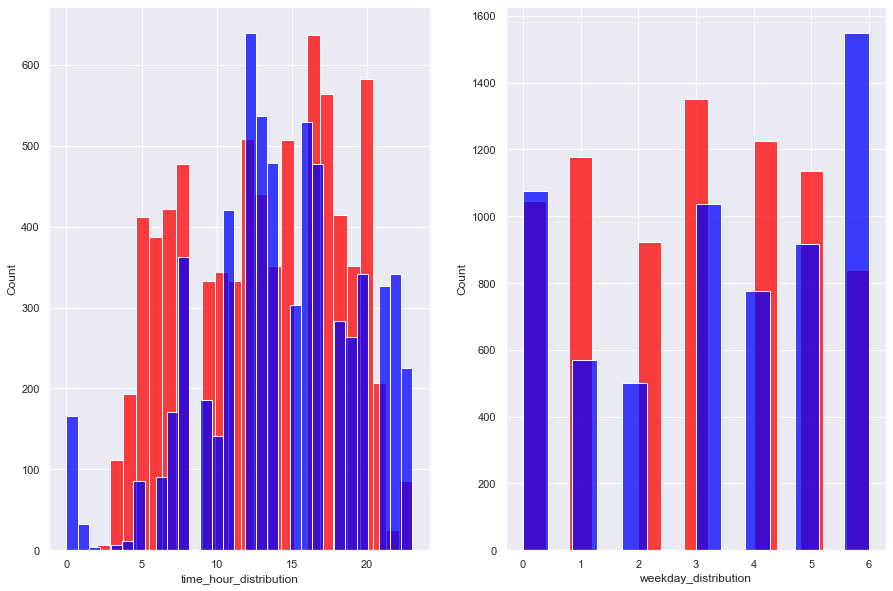

In [30]:
# оценим распределение времени активности для самой активной эталонной пары
# как можно заметить - средние довольно близки, а вот моды сильно разнятся
# дисперсии распределения времени активности внутри суток очень схожи, а вот дисперсии распределения дней недели разнятся
fig, axs = plt.subplots(1,2)
sns.histplot(data= df_data.loc[df_data.hash_id == 1070773], x= "time_hour" , ax=axs[0],  color="red").set_xlabel('time_hour_distribution')
sns.histplot(data= df_data.loc[df_data.hash_id == 2797567], x= "time_hour", ax=axs[0],  color="blue")
sns.histplot(data= df_data.loc[df_data.hash_id == 1070773], x= "weekday" , ax=axs[1],  color="red").set_xlabel('weekday_distribution')
sns.histplot(data= df_data.loc[df_data.hash_id == 2797567], x= "weekday" , ax=axs[1],  color="blue")
print("среднее время активности в сутках для id1 : ", round(df_data.loc[df_data.hash_id == 1070773].time_hour.mean(),2), 
        "\nсреднее время активности в сутках для id2 : ", round(df_data.loc[df_data.hash_id == 2797567].time_hour.mean(),2))
print("средний день активности в неделе для id1 : ", round(df_data.loc[df_data.hash_id == 1070773].weekday.mean(),2), 
        "\nсредний день активности в неделе для id2 : ", round(df_data.loc[df_data.hash_id == 2797567].weekday.mean(),2))
print("самое распространенное время активности в сутках для id1 : ",  df_data.loc[df_data.hash_id == 1070773].time_hour.mode(), 
        "\nсамое распространенное время активности в сутках для id2 : ", df_data.loc[df_data.hash_id == 2797567].time_hour.mode())
print("самый распространенный день активности в неделе для id1 : ", df_data.loc[df_data.hash_id == 1070773].weekday.mode(), 
        "\nсамый распространенный день активности в неделе для id2 : ", df_data.loc[df_data.hash_id == 2797567].weekday.mode())
print("дисперсия времени активности в сутках для id1 :  ", df_data.loc[df_data.hash_id == 1070773].time_hour.var(ddof=0),
        "\nдисперсия времени активности в сутках для id2 :  ", df_data.loc[df_data.hash_id == 2797567].time_hour.var(ddof=0))
print("дисперсия дней активности в неделе для для id1 :  ", df_data.loc[df_data.hash_id == 1070773].weekday.var(ddof=0),
        "\nдисперсия дней активности в неделе для id2 :  ", df_data.loc[df_data.hash_id == 2797567].weekday.var(ddof=0))
print("экспонента моды дней активности в неделе для id1 : ", np.exp(df_data.loc[df_data.hash_id == 1070773].weekday.mode()), 
        "\nэкспонента моды дней активности в неделе для id2 : ", np.exp(df_data.loc[df_data.hash_id == 2797567].weekday.mode()))

In [31]:
np.sqrt(df_data.loc[df_data.hash_id == 1070773].time_hour.mode())

0    4.0
dtype: float64

In [32]:
# оценим распределение времени для 2 по активности пары
df_etalon[df_etalon.id2 == 2943025]

,id1,id2
73,1820793,2943025


среднее время активности в сутках для id1 :  11.34 
среднее время активности в сутках для id2 :  10.99
средний день активности в неделе для id1 :  2.82 
средний день активности в неделе для id2 :  2.73
самое распространенное время активности в сутках для id1 :  0    11
dtype: int64 
самое распространенное время активности в сутках для id2 :  0    14
dtype: int64
самый распространенный день активности в неделе для id1 :  0    1
dtype: int64 
самый распространенный день активности в неделе для id2 :  0    4
dtype: int64
дисперсия времени активности в сутках для id1 :   19.917684948741204 
дисперсия времени активности в сутках для id2 :   19.05412866836985
дисперсия дней активности в неделе для для id1 :   3.9467944780608275 
дисперсия дней активности в неделе для id2 :   3.4108142331584097
экспонента моды дней активности в неделе для id1 :  0    2.718282
dtype: float64 
экспонента моды дней активности в неделе для id2 :  0    54.59815
dtype: float64


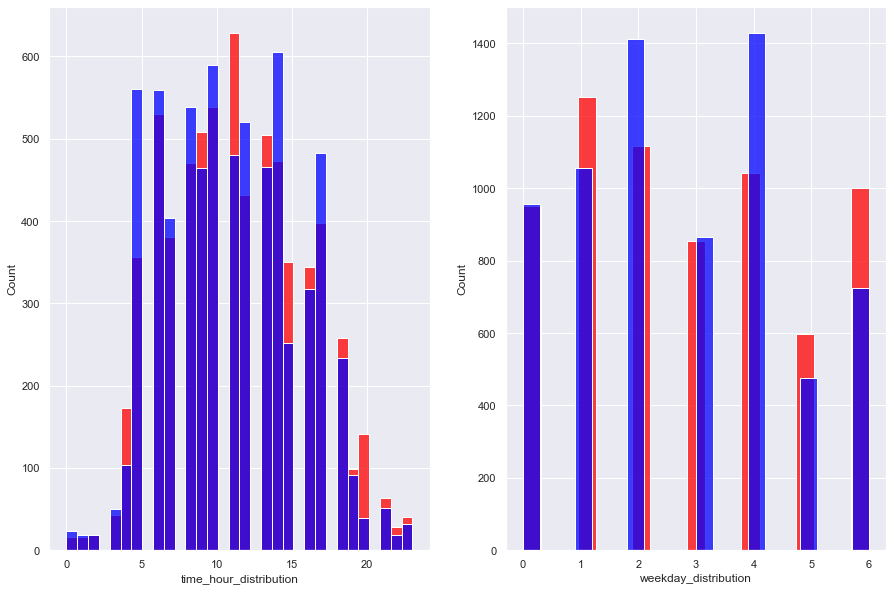

In [33]:
# аналогично - средние близки, моды сильно разнятся, распределения времени активности внутри суток очень схожи, а вот дисперсии распределения дней недели разнятся
fig, axs = plt.subplots(1,2)
sns.histplot(data= df_data.loc[df_data.hash_id == 1820793], x= "time_hour" , ax=axs[0],  color="red").set_xlabel('time_hour_distribution')
sns.histplot(data= df_data.loc[df_data.hash_id == 2943025], x= "time_hour" , ax=axs[0],  color="blue")
sns.histplot(data= df_data.loc[df_data.hash_id == 1820793], x= "weekday" , ax=axs[1],  color="red").set_xlabel('weekday_distribution')
sns.histplot(data= df_data.loc[df_data.hash_id == 2943025], x= "weekday" , ax=axs[1],  color="blue")
print("среднее время активности в сутках для id1 : ", round(df_data.loc[df_data.hash_id == 1820793].time_hour.mean(),2), 
        "\nсреднее время активности в сутках для id2 : ", round(df_data.loc[df_data.hash_id == 2943025].time_hour.mean(),2))
print("средний день активности в неделе для id1 : ", round(df_data.loc[df_data.hash_id == 1820793].weekday.mean(),2), 
        "\nсредний день активности в неделе для id2 : ", round(df_data.loc[df_data.hash_id == 2943025].weekday.mean(),2))
print("самое распространенное время активности в сутках для id1 : ", df_data.loc[df_data.hash_id == 1820793].time_hour.mode(), 
        "\nсамое распространенное время активности в сутках для id2 : ", df_data.loc[df_data.hash_id == 2943025].time_hour.mode())
print("самый распространенный день активности в неделе для id1 : ", df_data.loc[df_data.hash_id == 1820793].weekday.mode(), 
        "\nсамый распространенный день активности в неделе для id2 : ", df_data.loc[df_data.hash_id == 2943025].weekday.mode())
print("дисперсия времени активности в сутках для id1 :  ", df_data.loc[df_data.hash_id == 1820793].time_hour.var(ddof=0),
        "\nдисперсия времени активности в сутках для id2 :  ", df_data.loc[df_data.hash_id == 2943025].time_hour.var(ddof=0))
print("дисперсия дней активности в неделе для для id1 :  ", df_data.loc[df_data.hash_id == 1820793].weekday.var(ddof=0),
        "\nдисперсия дней активности в неделе для id2 :  ", df_data.loc[df_data.hash_id == 2943025].weekday.var(ddof=0))
print("экспонента моды дней активности в неделе для id1 : ", np.exp(df_data.loc[df_data.hash_id == 1820793].weekday.mode()), 
        "\nэкспонента моды дней активности в неделе для id2 : ", np.exp(df_data.loc[df_data.hash_id == 2943025].weekday.mode()))

In [34]:
# выберем самых активных неэталонных юзеров для оценки зависимости распределения времени активности 
df_data.loc[~df_data.hash_id.isin(list_etalon1+list_etalon2)]\
  .groupby("hash_id", as_index=False).agg({"lac":"nunique", "cid":"nunique"})\
    .sort_values(["cid","lac"], ascending=False)

,hash_id,lac,cid
2352,2330455,175,3871
214,1127318,158,3519
802,1455018,208,3391
2401,2355966,185,3141
2429,2374514,155,2849
...,...,...,...
1580,1895921,1,1
2543,2444261,1,1
3203,2815134,1,1
3319,2882986,1,1


среднее время активности в сутках для эталонного юзера :  11.34 
среднее время активности в сутках для не эталонного юзера :  10.66
средний день активности в неделе для эталонного юзера :  2.82 
средний день активности в неделе для не эталонного юзера :  3.17
самое распространенное время активности в сутках для эталонного юзера :  0    11
dtype: int64 
самое распространенное время активности в сутках для не эталонного юзера :  0    4
dtype: int64
самый распространенный день активности в неделе для эталонного юзера :  0    1
dtype: int64 
самый распространенный день активности в неделе для не эталонного юзера :  0    6
dtype: int64
дисперсия времени активности в сутках для для эталонного юзера :   19.917684948741204 
дисперсия времени активности в сутках для не эталонного юзера :   34.05241822308636
дисперсия дней активности в неделе для для эталонного юзера :   3.9467944780608275 
дисперсия дней активности в неделе для не эталонного юзера :   5.237523487388359
экспонента моды дней акти

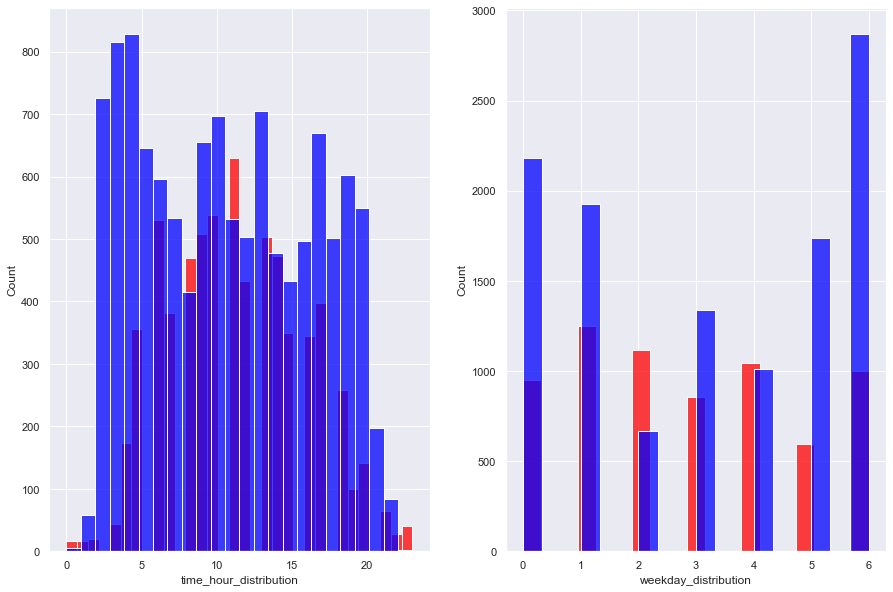

In [35]:
# теперь сравним с двумя другими активными неэталонными пользователями, самого активного эталонного
# в этом случае видим, что средние оказались близки, хотя распределения значительно отличаются, а вот моды очень сильно разошлись 
# дисперсии распределения времени активности внутри суток очень разнятся, а вот дисперсии распределения дней недели схожи
fig, axs = plt.subplots(1,2)
sns.histplot(data= df_data.loc[df_data.hash_id == 1820793], x= "time_hour" , ax=axs[0],  color="red").set_xlabel('time_hour_distribution')
sns.histplot(data= df_data.loc[df_data.hash_id == 2330455], x= "time_hour" , ax=axs[0],  color="blue")
sns.histplot(data= df_data.loc[df_data.hash_id == 1820793], x= "weekday" , ax=axs[1],  color="red").set_xlabel('weekday_distribution')
sns.histplot(data= df_data.loc[df_data.hash_id == 2330455], x= "weekday" , ax=axs[1],  color="blue")
print("среднее время активности в сутках для эталонного юзера : ", round(df_data.loc[df_data.hash_id == 1820793].time_hour.mean(),2), 
        "\nсреднее время активности в сутках для не эталонного юзера : ", round(df_data.loc[df_data.hash_id == 2330455].time_hour.mean(),2))
print("средний день активности в неделе для эталонного юзера : ", round(df_data.loc[df_data.hash_id == 1820793].weekday.mean(),2), 
        "\nсредний день активности в неделе для не эталонного юзера : ", round(df_data.loc[df_data.hash_id == 2330455].weekday.mean(),2))
print("самое распространенное время активности в сутках для эталонного юзера : ", df_data.loc[df_data.hash_id == 1820793].time_hour.mode(), 
        "\nсамое распространенное время активности в сутках для не эталонного юзера : ", df_data.loc[df_data.hash_id == 2330455].time_hour.mode())
print("самый распространенный день активности в неделе для эталонного юзера : ", df_data.loc[df_data.hash_id == 1820793].weekday.mode(), 
        "\nсамый распространенный день активности в неделе для не эталонного юзера : ", df_data.loc[df_data.hash_id == 2330455].weekday.mode())
print("дисперсия времени активности в сутках для для эталонного юзера :  ", df_data.loc[df_data.hash_id == 1820793].time_hour.var(ddof=0),
        "\nдисперсия времени активности в сутках для не эталонного юзера :  ", df_data.loc[df_data.hash_id == 2330455].time_hour.var(ddof=0))
print("дисперсия дней активности в неделе для для эталонного юзера :  ", df_data.loc[df_data.hash_id == 1820793].weekday.var(ddof=0),
        "\nдисперсия дней активности в неделе для не эталонного юзера :  ", df_data.loc[df_data.hash_id == 2330455].weekday.var(ddof=0))
print("экспонента моды дней активности в неделе для id1 : ", np.exp(df_data.loc[df_data.hash_id == 1820793].weekday.mode()), 
        "\nэкспонента моды дней активности в неделе для id2 : ", np.exp(df_data.loc[df_data.hash_id == 2330455].weekday.mode()))

среднее время активности в сутках для эталонного юзера :  11.34 
среднее время активности в сутках для не эталонного юзера :  10.44
средний день активности в неделе для эталонного юзера :  2.82 
средний день активности в неделе для не эталонного юзера :  3.05
самое распространенное время активности в сутках для эталонного юзера :  0    11
dtype: int64 
самое распространенное время активности в сутках для не эталонного юзера :  0    2
dtype: int64
самый распространенный день активности в неделе для эталонного юзера :  0    1
dtype: int64 
самый распространенный день активности в неделе для не эталонного юзера :  0    6
dtype: int64
дисперсия времени активности в сутках для для эталонного юзера :   19.917684948741204 
дисперсия времени активности в сутках для не эталонного юзера :   34.754109061354484
дисперсия дней активности в неделе для для эталонного юзера :   3.9467944780608275 
дисперсия дней активности в неделе для не эталонного юзера :   4.894168304892915
экспонента моды дней акт

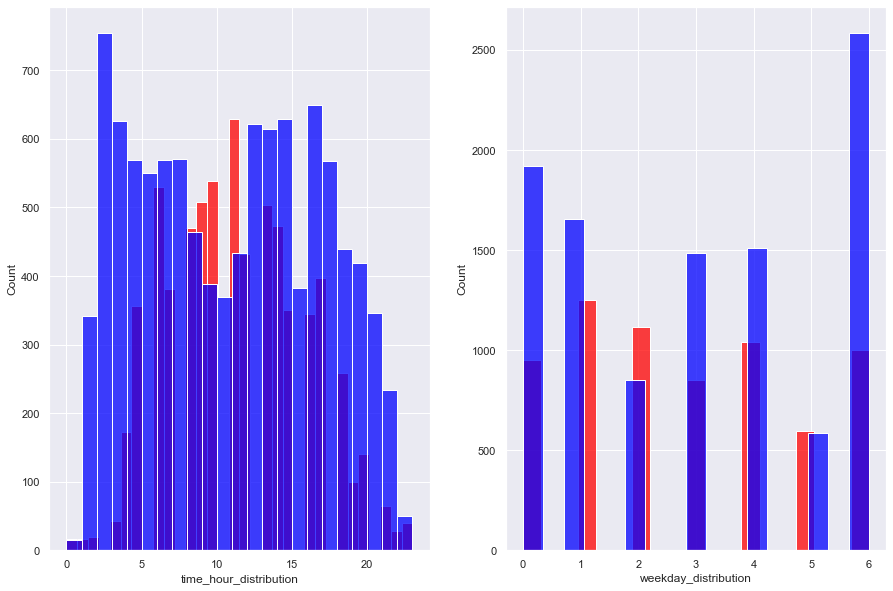

In [36]:
# аналогично видим, что средние оказались близки, хотя распределения значительно отличаются, а вот моды очень сильно разошлись,
# дисперсии распределения времени активности внутри суток очень разнятся, а вот дисперсии распределения дней недели схожи
fig, axs = plt.subplots(1,2)
sns.histplot(data= df_data.loc[df_data.hash_id == 1820793], x= "time_hour" , ax=axs[0],  color="red").set_xlabel('time_hour_distribution')
sns.histplot(data= df_data.loc[df_data.hash_id == 1127318], x= "time_hour" , ax=axs[0],  color="blue")
sns.histplot(data= df_data.loc[df_data.hash_id == 1820793], x= "weekday" , ax=axs[1],  color="red").set_xlabel('weekday_distribution')
sns.histplot(data= df_data.loc[df_data.hash_id == 1127318], x= "weekday" , ax=axs[1],  color="blue")
print("среднее время активности в сутках для эталонного юзера : ", round(df_data.loc[df_data.hash_id == 1820793].time_hour.mean(),2), 
        "\nсреднее время активности в сутках для не эталонного юзера : ", round(df_data.loc[df_data.hash_id == 1127318].time_hour.mean(),2))
print("средний день активности в неделе для эталонного юзера : ", round(df_data.loc[df_data.hash_id == 1820793].weekday.mean(),2), 
        "\nсредний день активности в неделе для не эталонного юзера : ", round(df_data.loc[df_data.hash_id == 1127318].weekday.mean(),2))
print("самое распространенное время активности в сутках для эталонного юзера : ", df_data.loc[df_data.hash_id == 1820793].time_hour.mode(), 
        "\nсамое распространенное время активности в сутках для не эталонного юзера : ", df_data.loc[df_data.hash_id == 1127318].time_hour.mode())
print("самый распространенный день активности в неделе для эталонного юзера : ", df_data.loc[df_data.hash_id == 1820793].weekday.mode(), 
        "\nсамый распространенный день активности в неделе для не эталонного юзера : ", df_data.loc[df_data.hash_id == 1127318].weekday.mode())
print("дисперсия времени активности в сутках для для эталонного юзера :  ", df_data.loc[df_data.hash_id == 1820793].time_hour.var(ddof=0),
        "\nдисперсия времени активности в сутках для не эталонного юзера :  ", df_data.loc[df_data.hash_id == 1127318].time_hour.var(ddof=0))
print("дисперсия дней активности в неделе для для эталонного юзера :  ", df_data.loc[df_data.hash_id == 1820793].weekday.var(ddof=0),
        "\nдисперсия дней активности в неделе для не эталонного юзера :  ", df_data.loc[df_data.hash_id == 1127318].weekday.var(ddof=0))
print("экспонента моды дней активности в неделе для id1 : ", np.exp(df_data.loc[df_data.hash_id == 1820793].weekday.mode()), 
        "\nэкспонента моды дней активности в неделе для id2 : ", np.exp(df_data.loc[df_data.hash_id == 1127318].weekday.mode()))

In [37]:
# После анализа взаимосвязи распределения времени активности внутри дня и по дням недели, можно сделать следующие выводы:
# 1) Дисперсия распределения времени активности внутри дня юзера слабо меняется после смены id - но сильно разнится между юзерами
# 2) Мода активности по дням недели особенно сильно разнится у разных юзеров - можно усилить эффект экспоненцированием и вычислять дельту


In [38]:
df_data

,lac,cid,ts,hash_id,time_date,time_hour,only_date,weekday,count_this_cid,count_this_lac,count_all_move,share_of_all_cid,share_of_all_lac,rank_cid,rank_lac
2368010,9701,197354757,1.536227e+09,1088711,2018-09-06 09:36:00,9,2018-09-06,3,6545,10250,34124,19.1800,30.0375,1.0,2.0
2366596,9701,197354757,1.536050e+09,1088711,2018-09-04 08:40:52,8,2018-09-04,1,6545,10250,34124,19.1800,30.0375,1.0,2.0
2366586,9701,197354757,1.536050e+09,1088711,2018-09-04 08:40:01,8,2018-09-04,1,6545,10250,34124,19.1800,30.0375,1.0,2.0
2366587,9701,197354757,1.536050e+09,1088711,2018-09-04 08:40:02,8,2018-09-04,1,6545,10250,34124,19.1800,30.0375,1.0,2.0
2366588,9701,197354757,1.536050e+09,1088711,2018-09-04 08:40:08,8,2018-09-04,1,6545,10250,34124,19.1800,30.0375,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3638902,9770,10159,1.536690e+09,1936187,2018-09-11 18:12:21,18,2018-09-11,1,1,1,659,0.1517,0.1517,18.0,9.0
3638908,7731,1214,1.536837e+09,1936187,2018-09-13 11:04:51,11,2018-09-13,3,1,3,659,0.1517,0.4552,18.0,7.0
3638909,5061,1250,1.536837e+09,1936187,2018-09-13 11:15:35,11,2018-09-13,3,1,3,659,0.1517,0.4552,18.0,7.0
3638910,5061,407,1.536851e+09,1936187,2018-09-13 15:00:20,15,2018-09-13,3,1,3,659,0.1517,0.4552,18.0,7.0


In [39]:
df_data["lac"] = df_data["lac"].astype("int")
df_data["cid"] = df_data["cid"].astype("int")
df_data["rank_lac"] = df_data["rank_lac"].astype("int")
df_data["rank_cid"] = df_data["rank_cid"].astype("int")
df_data["count_all_move"] = df_data["count_all_move"].astype("int")
df_test_pivot = df_data.copy()

In [40]:
def rename_lac_columns(old_columns):
    new_columns = "lac_category_top_" + str(old_columns)
    return new_columns

def rename_cid_columns(old_columns):
    new_columns = "cid_category_top_" + str(old_columns)
    return new_columns

def rename_share_lac_columns(old_columns):
    new_columns = "share_lac_category_top_" + str(old_columns)
    return new_columns

def rename_share_cid_columns(old_columns):
    new_columns = "share_cid_category_top_" + str(old_columns)
    return new_columns

In [41]:
# соберем данные топ-20 категорий для каждого пользователя по lac и cid
# выведем значения топ-20 категорий lac в качестве фичей
users_rank_lac = pd.pivot_table(df_test_pivot.query('rank_lac < 21 '), values="lac", index="hash_id", columns="rank_lac" , fill_value = 0)
users_rank_lac = users_rank_lac.rename(columns=rename_lac_columns)
users_rank_lac.reset_index(inplace=True)
users_rank_lac = users_rank_lac.astype("int")

# выведем значения топ-20 категорий cid в качестве фичей
users_rank_cid = pd.pivot_table(df_test_pivot.query('rank_cid < 21 '), values="cid", index="hash_id", columns="rank_cid" , fill_value = 0)
users_rank_cid = users_rank_cid.rename(columns=rename_cid_columns)
users_rank_cid.reset_index(inplace=True)
users_rank_cid = users_rank_cid.astype("int")

# выведем значения долей топ-20 категорий lac в качестве фичей
users_share_rank_lac = pd.pivot_table(df_data.query('rank_lac < 21 '), values="share_of_all_lac", index="hash_id", columns="rank_lac" , fill_value = 0)
users_share_rank_lac = users_share_rank_lac.rename(columns=rename_share_lac_columns)
users_share_rank_lac.reset_index(inplace=True)

# выведем значения долей топ-20 категорий cid в качестве фичей
users_share_rank_cid = pd.pivot_table(df_data.query('rank_cid < 21 '), values="share_of_all_cid", index="hash_id", columns="rank_cid" , fill_value = 0)
users_share_rank_cid = users_share_rank_cid.rename(columns=rename_share_cid_columns)
users_share_rank_cid.reset_index(inplace=True)



In [42]:
# расчитаем дисперсию времени активности в сутках для каждого юзера, а также экспоненту моды дней активности в неделе
df_var_time_hour = df_data.groupby("hash_id", as_index=False)["time_hour"].var().rename(columns={"time_hour":"var_time_hour"})
df_exp_mode_weekday = df_data.groupby("hash_id", as_index=False)["weekday"].agg(lambda x: np.max(np.exp(x.mode()))).rename(columns={"weekday":"exp_mode_weekday"})


In [43]:
# смержим все фичи
df_all_feaches = users_rank_cid.merge(users_rank_lac, on="hash_id")\
  .merge(users_share_rank_lac, on="hash_id")\
    .merge(users_share_rank_cid, on="hash_id")\
      .merge(df_count_all_move, on="hash_id")\
        .merge(df_var_time_hour, on="hash_id")\
          .merge(df_exp_mode_weekday, on="hash_id")
df_all_feaches

,hash_id,cid_category_top_1,cid_category_top_2,cid_category_top_3,cid_category_top_4,cid_category_top_5,cid_category_top_6,cid_category_top_7,cid_category_top_8,cid_category_top_9,...,share_cid_category_top_14,share_cid_category_top_15,share_cid_category_top_16,share_cid_category_top_17,share_cid_category_top_18,share_cid_category_top_19,share_cid_category_top_20,count_all_move,var_time_hour,exp_mode_weekday
0,1000773,28387,19082,15677,18056,1495,55086,6026,47149,14642,...,0.3017,0.1508,0.0000,0.0000,0.0000,0.0000,0.0000,663,18.655361,403.428793
1,1000808,34606,3578,3579,33102,60325,57210,39591,9553,32901,...,0.5973,0.4616,0.3258,0.2715,0.1901,0.1629,0.1358,3683,69.189290,1.000000
2,1000868,198781188,15386626,15386646,129594625,198734595,214654083,198588676,198056964,57377,...,1.1696,1.1046,1.0721,1.0071,0.9747,0.9097,0.8122,3078,32.963558,54.598150
3,1001103,8585,8570,8586,22606,870,21327,46835,10150,6121,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,377,13.344376,20.085537
4,1001168,34957,2284,2265,2278,7572,3497,1750,1752,34958,...,0.7260,0.5445,0.3630,0.1815,0.0000,0.0000,0.0000,551,33.036185,54.598150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4522,2998617,15676161,15676172,197361921,230798593,197361932,8621,197252609,230798595,248533508,...,0.7463,0.6397,0.5330,0.4264,0.3198,0.2132,0.1066,938,24.479856,54.598150
4523,2999034,19580,46818,3657,30571,3656,1880,14642,1545,966,...,1.1788,1.0806,0.7859,0.6876,0.5894,0.4912,0.3929,1018,19.944670,2.718282
4524,2999248,15416834,198759171,15416854,198704388,198759200,128960001,6440,197981188,6190,...,0.8565,0.8208,0.7852,0.7495,0.7138,0.6424,0.6067,2802,19.125887,2.718282
4525,2999753,1011,10101,64107,44328,5328,42161,31253,34227,34221,...,0.7440,0.6696,0.5952,0.5580,0.5208,0.4836,0.4464,2688,26.541119,1.000000


In [44]:
df_etalon["target"] = 1

In [45]:
df_single_1 = pd.DataFrame({'id1': list_single1, "target" : 0})
df_single_2 = pd.DataFrame({'id2': list_single2, "target" : 0})
df_single = df_single_1.merge(df_single_2, on='target', how='outer')
df_single = df_single.reindex(columns=['id1','id2',"target"])

In [46]:
df_target = pd.concat([df_etalon,df_single])
df_target

,id1,id2,target
0,1361396,2695335,1
1,1795864,2458905,1
2,1543059,2730453,1
3,1028066,2539971,1
4,1533076,2712514,1
...,...,...,...
3155605,1769461,2063508,0
3155606,1769461,2687626,0
3155607,1769461,2360136,0
3155608,1769461,2327766,0


In [47]:
df_all_feaches_id1 = df_all_feaches.loc[df_all_feaches.hash_id.isin(list_id1)].rename(columns={"hash_id":"id1"})
df_all_feaches_id2 = df_all_feaches.loc[df_all_feaches.hash_id.isin(list_id2)].rename(columns={"hash_id":"id2"})

In [48]:

df_merge_feach_target = df_target.merge(df_all_feaches_id1, on="id1").merge(df_all_feaches_id2, on="id2")
df_merge_feach_target

,id1,id2,target,cid_category_top_1_x,cid_category_top_2_x,cid_category_top_3_x,cid_category_top_4_x,cid_category_top_5_x,cid_category_top_6_x,cid_category_top_7_x,...,share_cid_category_top_14_y,share_cid_category_top_15_y,share_cid_category_top_16_y,share_cid_category_top_17_y,share_cid_category_top_18_y,share_cid_category_top_19_y,share_cid_category_top_20_y,count_all_move_y,var_time_hour_y,exp_mode_weekday_y
0,1361396,2695335,1,19205,29526,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,14,26.181319,54.598150
1,1795864,2458905,1,836,30571,36531,23597,22345,0,0,...,0.4747,0.3165,0.1582,0.0000,0.0000,0.0000,0.0000,632,24.243734,7.389056
2,1543059,2730453,1,61258,17211,32952,8571,10847,30571,32974,...,1.1872,1.0959,0.8219,0.7306,0.6393,0.5479,0.4566,1095,32.297009,403.428793
3,1028066,2539971,1,2265,29904,10292,24013,22255,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,40,32.061538,1.000000
4,1533076,2712514,1,6972,33248,6970,18884,7070,46780,35302,...,0.2625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,381,20.081600,148.413159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3150706,1449958,2920980,0,813,39810,897,498,2038,10276,30228,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,37,5.048048,403.428793
3150707,1228774,2920980,0,38380,380,16445,23128,16110,24074,30770,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,37,5.048048,403.428793
3150708,1753064,2920980,0,8527,35360,6475,20853,12080,25354,33087,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,37,5.048048,403.428793
3150709,1941490,2920980,0,47382,47362,128234755,197507340,12801,15675905,12803,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,37,5.048048,403.428793


In [49]:
df_test_exp_mode = df_data.groupby("hash_id", as_index=False)["weekday"].agg(lambda x: np.max(np.exp(x.mode()))).rename(columns={"weekday":"exp_mode_weekday"})
df_test_exp_mode.loc[df_test_exp_mode.hash_id == 2695335]

,hash_id,exp_mode_weekday
3824,2695335,54.59815
